# Julia Example

Jupyter has excellent support for the Julia language. Here we show some examples of using Julia

You can also run this notebook interactively in the cloud with binder:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/samprager/jupyterIntroduction/master?filepath=juliaexample.ipynb)

## Useful Links

- [Julia Documentation](https://docs.julialang.org/en/v1/)
- [Julia Performance Tips](https://docs.julialang.org/en/v1/manual/performance-tips/)
- [Julia Syle Guide](https://docs.julialang.org/en/v1/manual/style-guide/)
- [julia/matlab/python cheat sheet](https://cheatsheets.quantecon.org)

## Installation

[Download](https://julialang.org/downloads/) and install Julia 

Or on MacOS with homebrew
```
brew install julia
```

Now launch julia in a terminal
```
julia
```

In the Julia command prompt run the commands
```
julia> using Pkg
julia> Pkg.add("IJulia")
```
Now you can run jupyter labs like normal with
```
jupyter lab
```
and you should see Julia from the available kernel list.

Or you can launch jupyter lab from inside julia with:
```
julia> using IJulia
julia> jupyterlab()
```

## Plotting with Plots.jl
The most basic plots are line plots. Assuming you have installed Plots.jl via 
```
Using Pkg
Pkg.add("Plots")
```
you can plot a line by calling plot on two vectors of numbers. For example:

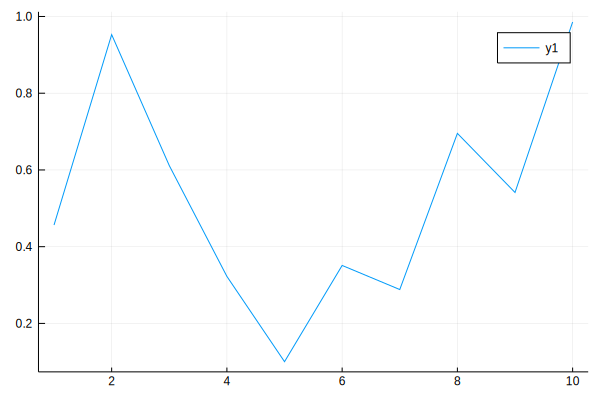

In [12]:
using Plots
x = 1:10; y = rand(10); # These are the plotting data
plot(x, y)

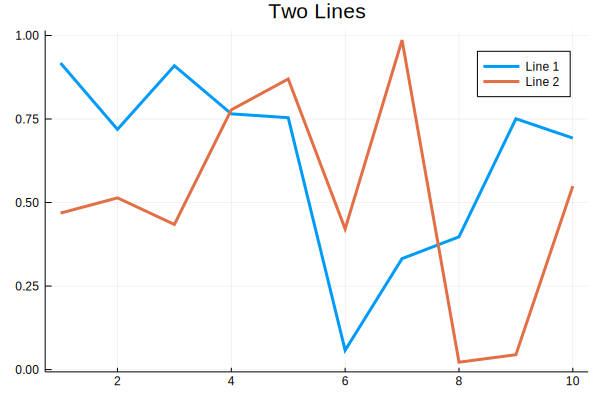

In [17]:
x = 1:10; y = rand(10, 2) # 2 columns means two lines
plot(x, y, title = "Two Lines", label = ["Line 1" "Line 2"], lw = 3)

## Generate and plot a Chirp

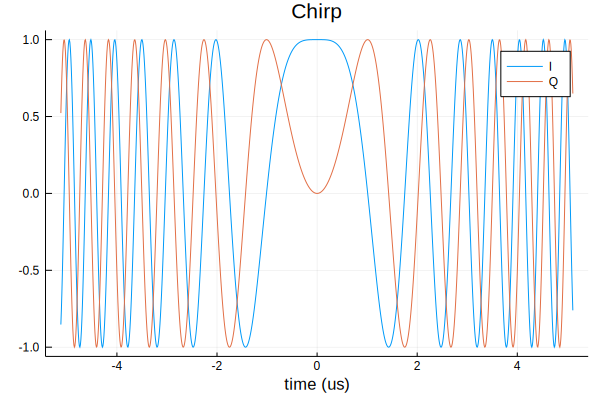

In [18]:
fs = 100e6;
N = 1024;
bw = 5e6;

n = (0:(N-1)).-N/2;
t = n/fs;

s = exp.(1im*pi*.5*(bw/t[end])*(t.^2));

plot(t*1e6,real(s),label="I")
plot!(t*1e6,imag(s),label="Q")

# This will also work:
# plot(t*1e6,[real(s) imag(s)],label=["I" "Q"])

xlabel!("time (us)")
title!("Chirp")

## Plotting with PyPlot

An alternative to Plots.jl is PyPlot.jl which is based on matplotlib.

[more examples](https://stanford.edu/class/ee103/julia_slides/julia_plotting_slides.pdf)

This package can be installed with 
```
using Pkg
Pkg.add("PyPlot");
```

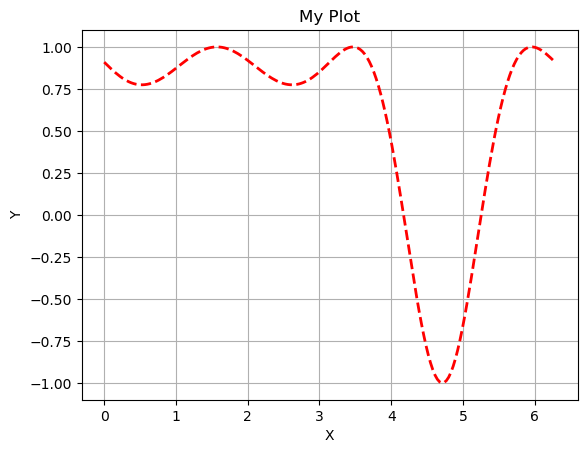

In [8]:
using PyPlot

clf(); # clear current plot
# x = linspace(0,2pi,200); # use in julia .6
x = range(0; stop=2*pi, length=200);
y = sin.(x+2*cos.(x)); 
plot(x,y,color="red",linewidth=2.0,linestyle="--")
xlabel("X");
ylabel("Y");
title("My Plot");
grid("on"); 

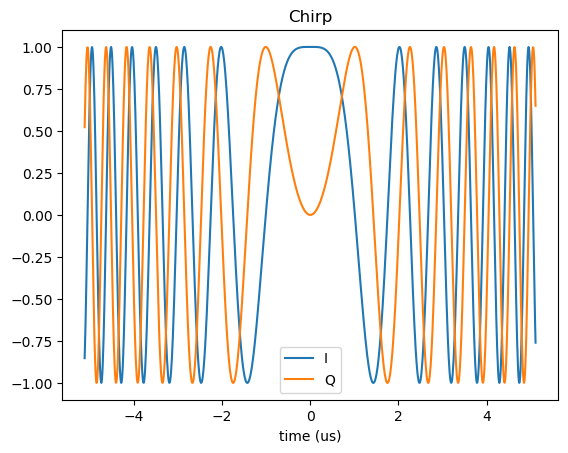

PyObject Text(0.5, 1, 'Chirp')

In [9]:
using PyPlot

clf(); # clear current plot

fs = 100e6;
N = 1024;
bw = 5e6;

n = (0:(N-1)).-N/2;
t = n/fs;

s = exp.(1im*pi*.5*(bw/t[end])*(t.^2));

plot(t*1e6,real(s),label="I")
plot(t*1e6,imag(s),label="Q")

xlabel("time (us)")
legend()
title("Chirp")

## Custom Modules

Here we have created our own Julia *Module* named `Waveforms` in the file [tools/julia/waveforms.jl](tools/julia/waveforms.jl). The moudle defines the functions `chirp()` and `mfiltu()`

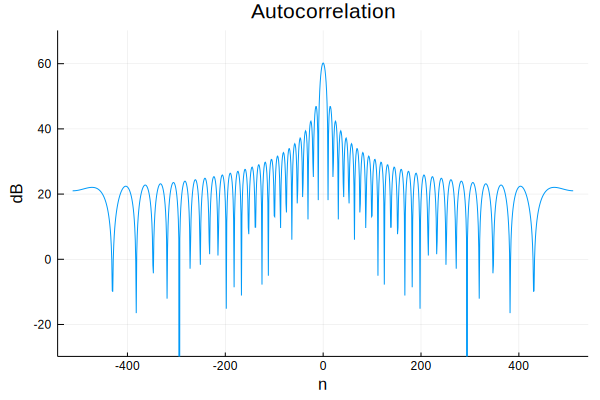

In [4]:
using Plots
include("./tools/julia/waveforms.jl")
using .Waveforms

fs = 100e6
N = 1024
bw = 10e6

n = (0:(N-1)).-N/2;
t = n/fs;
s=chirp(t,bw);

d,l = mfiltu(s,s);

ddb = 20*log10.(abs.(d));
plot(l,ddb,label=nothing)
xlabel!("n")
ylabel!("dB")
title!("Autocorrelation")
ylims!((maximum(ddb)-90,maximum(ddb)+10))

For reference, the contents of [tools/julia/waveforms.jl](tools/julia/waveforms.jl) are read and printed below (using Julia).

Note that this module requires FFTW (Pkg.add("FFTW"))

In [5]:
println(open(f->read(f, String), "tools/julia/waveforms.jl"))

module Waveforms

using FFTW

export chirp, mfiltu, zeropad, zeroext

# function chirp(t,bw)
# Description:
#   Generate LFM chirp from time index t with bandwidth bw
function chirp(t,bw)
    return exp.(1im*pi*.5*(bw/t[end])*(t.^2));
end

# function zeropad(x,nzero,mode::String="back")
# Description:
#    Add nzero zeros to vector x.
# Inputs:
#    x - sample vector
#    nzero - number of zeros to add
#    mode - "back" (default): append zeros to back of vector
#           "front": preappend zeros to front of vector
function zeropad(x,nzero,mode::String="back")
    if (mode=="back")
        xpad = [x; zeros(eltype(x),max(0,Int(nzero)))];
    else
        xpad = [zeros(eltype(x),max(0,Int(nzero)));x];
    end
    return xpad;
end

# function zeroext(x,n,mode::String="back")
# Description:
#    Extend vector x to length n by adding zeros
# Inputs:
#    x - sample vector
#    n - desired length of x
#    mode - "back" (default): append zeros to back of vector
#           "front": preappe

## Binary File I/O

Reading/Writing binary files is a little tricky in julia. Binary file reading requires array sizes to be predefined.

We define a function `file2wave()`

In [6]:
function file2wave(fname::String, ::Type{T}=Int16) where T
#     
# We can get the file size by seeking and managing the file context manually (like in Matlab)
#     
#     f = open(fname,"r")
#     seekend(f);
#     a=position(f);
#     seekstart(f);
#     nbytes=Int64(a/sizeof(T));
#     A = Array{T, 1}(undef, nbytes);
#     read!(f, A);
#     close(f);
#     
# Or we can use the filesize() function. Julia (like python) also features context managers 
# which facilitate the proper handling of resources. So we may equivalently write:   
    
    nbytes=Int64(filesize(fname)/sizeof(T));
    A = Array{T, 1}(undef, nbytes);
    open(fname,"r") do f
        read!(f, A);
    end
    
    if (occursin(".bin",fname)) 
        # waveform input files
        s = A[2:2:end] + 1im*A[1:2:end];
    else 
        # IQ data files (.dat, .ref)
        s = A[1:2:end] + 1im*A[2:2:end];
    end
    return s;
end

file2wave (generic function with 2 methods)

and call it to read in binary waveforms files from the `tools/waveforms` directory.

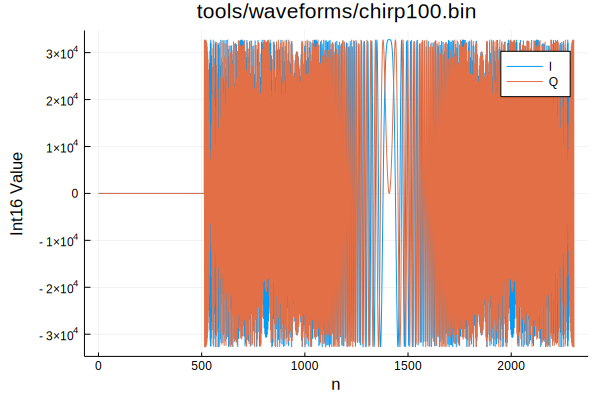

In [7]:
fname = "tools/waveforms/chirp100.bin";
s = file2wave(fname,Int16);
plot([real.(s) imag.(s)],label=["I" "Q"])
title!(fname)
ylabel!("Int16 Value")
xlabel!("n")

Now we define a function `wave2file()` to write waveform data as binary files

In [10]:
function wave2file(s, fname::String, ::Type{T}=Int16) where T
    sI = real.(s);
    sQ = imag.(s);
    maxS = max(maximum(abs.(sI)),maximum(abs.(sQ)));
    scale = 1;
    # will only apply scaling if waveform is between +-1 and output type is fixed point
    if ((maxS<=1) && (!isinf(typemax(T))))
        scale = typemax(T)/maxS;
    end
    if (isinf(typemax(T))) # floating point type
        sI = convert.(T,scale*sI);
        sQ = convert.(T,scale*sQ);
    else # fixed point type
        sI = convert.(T,round.(scale*sI));
        sQ = convert.(T,round.(scale*sQ));
    end
    if (occursin(".bin",fname))
        A = [sQ sI];
    else
        A = [sI sQ];
    end
    A = reshape(transpose(A),length(A),1);
    
# Manual file context management:
#     f = open(fname,"w")
#     write(f,A);
#     close(f);
# Using file context manager:
    open(fname,"w") do f
        write(f, A);
    end
end

wave2file (generic function with 2 methods)

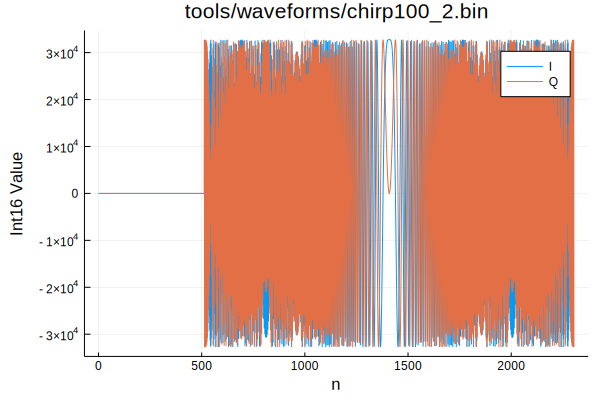

In [11]:
fname = "tools/waveforms/chirp100_2.bin";
s0 = s;
s0 = s0/(max(maximum(abs.(real.(s0))),maximum(abs.(imag.(s0)))));
wave2file(s0,fname);

s1 = file2wave(fname);
plot([real.(s1) imag.(s1)],label=["I" "Q"])
title!(fname)
ylabel!("Int16 Value")
xlabel!("n")

## Reading/Writing HDF5 with JLD2

[JLD2](https://github.com/JuliaIO/JLD2.jl) enables HDF5-compatible file format in pure Julia

JLD2 saves and loads Julia data structures in a format comprising a subset of HDF5, without any dependency on the HDF5 C library.

Install with `Pkg.add("JLD2")`

### Using save and load macros

In [15]:
using JLD2
# read in binary file as example
s = file2wave("tools/waveforms/chirp100.bin",Int16);
# save as jld2
@save "tools/waveforms/chirp100.jld2" s

println("Binary file size: ",filesize("tools/waveforms/chirp100.bin"))
println("JLD2 file size: ",filesize("tools/waveforms/chirp100.jld2"))

Binary file size: 9216
JLD2 file size: 42165


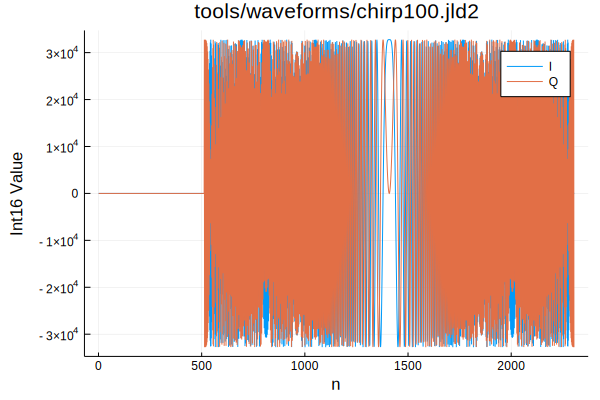

In [23]:
s=0;
@load "tools/waveforms/chirp100.jld2" s
plot([real.(s) imag.(s)],label=["I" "Q"])
title!("tools/waveforms/chirp100.jld2")
ylabel!("Int16 Value")
xlabel!("n")

### Using save and load functions

The `save` and `load` functions, provided by `FileIO`, provide an alternative mechanism to read and write data from a JLD2 file. To use these functions, you must say `using FileIO`; it is not necessary to say `using JLD2` since FileIO will determine the correct package automatically.

The `save` function accepts an `Associative` yielding the key/value pairs, where the key is a string representing the name of the dataset and the value represents its contents:

In [78]:
using FileIO
save("tools/julia/example.jld2", Dict("hello" => "world", "foo" => :bar))

The `save` function can also accept the dataset names and contents as arguments:

In [79]:
save("tools/julia/example.jld2", "hello", "world", "foo", :bar)

If called with a filename argument only, the load function loads all datasets from the given file into a Dict:

In [80]:
load("tools/julia/example.jld2") # -> Dict{String,Any}("hello" => "world", "foo" => :bar)

Dict{String,Any} with 2 entries:
  "hello" => "world"
  "foo"   => :bar

If called with a single dataset name, load returns the contents of that dataset from the file:

In [81]:
load("tools/julia/example.jld2", "hello") # -> "world"

"world"

If called with multiple dataset names, load returns the contents of the given datasets as a tuple:

In [82]:
load("tools/julia/example.jld2", "hello", "foo") # -> ("world", :bar)

("world", :bar)

## Reading MAT files
The [`MAT` package](https://github.com/JuliaIO/MAT.jl) can be used to read/write MATLAB .mat files in Julia. Beware that this is not a lightweight or pure julia package and has a HDF5 C library dependency.

Install with `Pkg.add("MAT")`

In Matlab we have the following code:
```
a=[1:10]
mystruct = struct;
mystruct.data = [1:10];
mystruct.str = "matlab struct";

save('tools/julia/example.mat','a','mystruct');
```

Now we load the `example.mat` file in Julia

In [83]:
using MAT
file = matopen("tools/julia/example.mat")
a=read(file, "a") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
dump(a)

Array{Float64}((1, 10)) [1.0 2.0 … 9.0 10.0]


To read all variables from a MAT file as a Dict:

In [84]:
vars = matread("tools/julia/example.mat")
println("vars[\"a\"]: \n",vars["a"],"\n")
println("\nvars[\"mystruct\"]: \n",vars["mystruct"],"\n")
mystruct = vars["mystruct"];
println("mystruct[\"str\"]:\n",mystruct["str"],"\n") # there are some issues with string encoding...
println("mystruct[\"data\"]:\n",mystruct["data"])

vars["a"]: 
[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0]


vars["mystruct"]: 
Dict{String,Any}("str" => Dict{String,Any}("s1" => Int8[77, 67, 79, 83],"arr" => ("", UInt32[0xdd000000; 0x00000002; 0x00000001; 0x00000001; 0x00000001; 0x00000001]),"s0" => Int8[],"s2" => Int8[115, 116, 114, 105, 110, 103]),"data" => [1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0])

mystruct["str"]:
Dict{String,Any}("s1" => Int8[77, 67, 79, 83],"arr" => ("", UInt32[0xdd000000; 0x00000002; 0x00000001; 0x00000001; 0x00000001; 0x00000001]),"s0" => Int8[],"s2" => Int8[115, 116, 114, 105, 110, 103])

mystruct["data"]:
[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0]


To write .mat data (`compress` argument is optional with default false):

In [85]:
matwrite("tools/julia/matfile.mat", Dict(
	"myvar1" => 0,
	"myvar2" => 1
); compress = true)